<a href="https://colab.research.google.com/github/srilamaiti/ml_works/blob/main/cancer_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***1. Installing New Libraries***

In [1]:
!pip install imgaug

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# ***2. Importing Libraries***

## ***A. Importing General Purpose Libraries***

In [2]:
import pandas as pd
import numpy as np
import os
import random
import joblib
import glob
import random
from itertools import product
import gc
import subprocess

## ***B. Importing Image Processing and Visualization Libraries***

In [3]:
from imutils import rotate as rotate
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import matplotlib.patches as patches
from matplotlib.patches import Polygon
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from skimage.color import gray2rgb
import skimage.io as skio
from imgaug import augmenters as img_aug
import imgaug as iaug

## ***C. Importing Sklearn Functionalities Libraries***

In [4]:
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold

## ***D. Importing Tensorflow Libraries***

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import RandomFlip
from tensorflow.keras.layers import RandomZoom
from tensorflow.keras.layers import RandomRotation
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Multiply
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import PReLU
from keras.layers.core import Activation
from keras.layers.convolutional import SeparableConv1D
from keras.layers.convolutional import SeparableConv2D

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop

from keras.applications.vgg16 import VGG16
from keras.applications.densenet import *
from keras.applications.resnet import ResNet152
from keras.applications.nasnet import NASNetMobile
from keras.applications.nasnet import NASNetLarge
from keras.applications.nasnet import preprocess_input
from keras.applications.inception_v3 import *

from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img

from tensorflow.python.ops.numpy_ops import np_config

from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.losses import mae
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.losses import binary_crossentropy

from keras.models import Model

# ***3. Mounting Google Drive***

In [6]:
# Required to read the data from Kaggle
from google.colab import drive
drive.mount('/content/gdrive')
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Kaggle"

Mounted at /content/gdrive


# ***4. File Processing***

## ***A. Downloading Image Files from Kaggle***

In [7]:
!kaggle competitions download -c histopathologic-cancer-detection

100% 6.30G/6.31G [00:46<00:00, 121MB/s]
100% 6.31G/6.31G [00:46<00:00, 146MB/s]


## ***B. Unzipping the Downaloaded Zip Files***

In [8]:
!unzip -o -qq \*.zip  && rm *.zip

## ***C. Data Validation and Spot Checks***

### ***a. Train Files Count***

In [9]:
!ls -ltr /content/train/ |wc -l

220026


### ***b. Validating Record Count of train_labels.csv with Train File Record Count***

In [10]:
!wc -l train_labels.csv

220026 train_labels.csv


### ***c. Test Files Count***

In [11]:
!ls -ltr /content/test/ |wc -l

57459


### ***d. Validating Record Count of sample_submission.csv with Test File Record Count***

In [12]:
!wc -l sample_submission.csv

57459 sample_submission.csv


### ***e. Explore File Structure of train_labels.csv***

In [13]:
!head train_labels.csv

id,label
f38a6374c348f90b587e046aac6079959adf3835,0
c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
755db6279dae599ebb4d39a9123cce439965282d,0
bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
068aba587a4950175d04c680d38943fd488d6a9d,0
acfe80838488fae3c89bd21ade75be5c34e66be7,0
a24ce148f6ffa7ef8eefb4efb12ebffe8dd700da,1
7f6ccae485af121e0b6ee733022e226ee6b0c65f,1
559e55a64c9ba828f700e948f6886f4cea919261,0


### ***f. Explore File Structure of sample_submission.csv***

In [14]:
!head sample_submission.csv

id,label
0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
95596b92e5066c5c52466c90b69ff089b39f2737,0
248e6738860e2ebcf6258cdc1f32f299e0c76914,0
2c35657e312966e9294eac6841726ff3a748febf,0
145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0
725dabe6ecccc68b958a2c7dd75bcbf362c7cb03,0
aa0307865281d4484ddf8c637c348292968b93a7,0
f4e5dc9c949920f1b3362982e15e99bf6f3ef83b,0
95e08c9cedc28a9b4a86f4fc1e06c1972134be08,0


# ***5. Support Functionalities***

## ***A. Defining Vartiables***

In [15]:
train_path = os.getcwd() + "/train/"
test_path = os.getcwd() + "/test/"

original_input_file_list = train_path + '*.tif'
original_output_file_list = test_path + '*.tif'

current_working_dir = os.getcwd()

train_label_file = 'train_labels.csv'
test_label_file = 'sample_submission.csv'

image_file_extension = '.tif'

train_files_path = os.path.join(current_working_dir, train_path)
test_files_path = os.path.join(current_working_dir, test_path)

split = (0.30, 0.10, 0.10)

random.seed(1)

## ***B. Misclenious Processing Class***

In [47]:
class misc_processing:
    """
    This class contains methods for misclenious processings.
    """
    def __init__(self):
        None
    
    def generate_fully_qualified_file_name_list(self, file_list):
        """
        This function generates a list of fully qualified file names.
        """
        qualified_file_name_list = [os.path.join(current_working_dir, train_path) + 
                                    img + 
                                    '.tif' 
                                    for img in file_list
                                   ]
        return qualified_file_name_list

    def print_image_original(self, image_file_list, label_list):
        """
        This function prints original images.
        """
        nrows, ncols = 1,4 #print first 4 images
        f, axs = plt.subplots(nrows, ncols, figsize=(14,12))
        for i, image in enumerate(image_file_list):
            axs[i].imshow(array_to_img(image))
            pf = Polygon(((32, 32), (64, 32), (64, 64), (32, 64)),
                         fc=(0.0, 0.0, 0.0, 0.0), 
                         ec=(0.0, 0.9, 0.0 ,0.9), lw=4, linestyle='--')
            pf.set_edgecolor('r')
            axs[i].add_patch(pf)
            axs[i].set(title=label_list[i])

    def print_image_in_diff_orientation(self, image_file):
        """
        This function prints images.
        """
        tf.random.set_seed(1234)
        fig = plt.figure(figsize=(14, 12))
        #fig = plt.figure()
        image = skio.imread(image_file, plugin = "tifffile")
        
        # plot original
        ax = fig.add_subplot(1, 5, 1)
        ax.imshow(array_to_img(image))
        pf = Polygon(((32, 32), (64, 32), (64, 64), (32, 64)),
                fc = (0.0, 0.0, 0.0, 0.0), 
                ec = (0.0, 0.9, 0.0 ,0.9), lw=4, linestyle='--')
        pf.set_edgecolor('r')
        ax.add_patch(pf)
        ax.set_title('Original', size=15);
        
        # resize
        ax = fig.add_subplot(1, 5, 2)
        img_resize = tf.image.resize(image, size=(224, 224))
        ax.imshow(array_to_img(img_resize))
        pf = Polygon(((80, 80), (144, 80), (144, 144), (80, 144)),
                fc = (0.0, 0.0, 0.0, 0.0), 
                ec = (0.0, 0.9, 0.0 ,0.9), lw=4, linestyle='--')
        pf.set_edgecolor('r')
        ax.add_patch(pf)
        ax.set_title('Step 1: Resize', size=15);
        
        # adjust brightness
        ax = fig.add_subplot(1, 5, 3)
        img_bright = tf.image.adjust_brightness(img_resize, 0.3)
        ax.imshow(array_to_img(img_bright))
        pf = Polygon(((80, 80), (144, 80), (144, 144), (80, 144)),
                fc = (0.0, 0.0, 0.0, 0.0), 
                ec = (0.0, 0.9, 0.0 ,0.9), lw=4, linestyle='--')
        pf.set_edgecolor('r')
        ax.add_patch(pf)
        ax.set_title('Step 2: Brightness', size=15);
        
        # adjust contrast
        ax = fig.add_subplot(1, 5, 4)
        img_contrast = tf.image.adjust_contrast(img_bright, contrast_factor=3)
        ax.imshow(array_to_img(img_contrast))
        pf = Polygon(((80, 80), (144, 80), (144, 144), (80, 144)),
                fc = (0.0, 0.0, 0.0, 0.0), 
                ec = (0.0, 0.9, 0.0 ,0.9), lw=4, linestyle='--')
        pf.set_edgecolor('r')
        ax.add_patch(pf)
        ax.set_title('Step 3: Contrast', size=15);
        
        # flip left right
        ax = fig.add_subplot(1, 5, 5)
        img_flip = tf.image.flip_left_right(img_contrast)
        ax.imshow(array_to_img(img_flip))
        pf = Polygon(((80, 80), (144, 80), (144, 144), (80, 144)),
                fc = (0.0, 0.0, 0.0, 0.0), 
                ec = (0.0, 0.9, 0.0 ,0.9), lw=4, linestyle='--')
        pf.set_edgecolor('r')
        ax.add_patch(pf)
        ax.set_title('Step 4: Flip left right');

    def split_data(self, split_indices, df):
        """
        This function splits the input dataframe in train, validation and test set.
        """
        X_train = df[: split_indices[0]]
        X_val = df[split_indices[0] : split_indices[1]]
        X_test = df[split_indices[1]:]
        return X_train, X_val, X_test
    
    def get_id_and_label_list(self, file_path, file_extension):
        """
        This function gets the imgae id and corresponding label.
        """
        return glob.glob(file_path + '*' + file_extension)
        '''
        file_list = []
        for file_name in glob.glob(file_path + '*' + file_extension):
            file_list.append(file_name)
        return file_list
        '''

    def create_label(self, shape, label = 1):
        """
        This function creates labels.
        """
        if label == 1:
            return np.ones(shape).flatten()
        elif label == 0:
            return np.zeros(shape).flatten()
    
    def compute_mean_and_std(self, image_file_list, r_mid_pos = 48, c_mid_pos = 48):
        """
        This function computes mean and std at the center of the image.
        """
        center_pixel_value_list = []
        for image_file in image_file_list:
            image = skio.imread(image_file, plugin = "tifffile")
            center_pixel_value_list.append(image[r_mid_pos, c_mid_pos])
        np_array_center_pixel_value = np.array(center_pixel_value_list)
        return np.mean(np_array_center_pixel_value), np.std(np_array_center_pixel_value)

    def copy_file_from_one_to_other(self, file_names, dest_path):
        "This function moves chunks of files in one to other."
        os.system('cp -r ' + file_names + ' ' + dest_path)

    def process_copy_files(self, file_name_list, dest_path):
        """"
        This function processes moving files from one dir to the other. 
        This is the master process to run actual moving in chunks.
        """
        process_chunk_size = 100
        for idx in range(0, len(file_name_list), process_chunk_size):
            if idx % 10000 == 0:
                print("Processing index: ", idx)
            self.copy_file_from_one_to_other(' '.join(file_name_list[idx : idx + process_chunk_size]), dest_path)
    
    def check_file_count_in_a_directory(self, dir_path):
        """
        This function checks the file count in a directory
        """
        cmd_string = 'ls ' + dir_path + " | wc -l"
        file_count = int(subprocess.check_output(cmd_string, shell=True, text=True).strip())
        return file_count

    def get_mini_batch_data(self, image_list, mini_batch_size):
        """
        This function performs as a generator to spit out data in small batches.
        """
        return (image_list[idx : idx + mini_batch_size] for idx in range(0, len(image_list), mini_batch_size))

    def get_aug_step_list(self):
        """
        This function executes image augmentation pipeline.
        """
        sometimes = lambda aug: img_aug.Sometimes(0.5, aug)
        img_aug_seq = img_aug.Sequential(
        [
            # apply the following augmenters to most images
            img_aug.Fliplr(0.5), # horizontally flip 50% of all images
            img_aug.Flipud(0.2), # vertically flip 20% of all images
            sometimes(img_aug.Affine(
                scale={"x": (0.9, 1.1), "y": (0.9, 1.1)}, # scale images to 80-120% of their size, individually per axis
                translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}, # translate by -20 to +20 percent (per axis)
                rotate=(-10, 10), # rotate by -45 to +45 degrees
                shear=(-5, 5), # shear by -16 to +16 degrees
                order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
                cval=(0, 255), # if mode is constant, use a cval between 0 and 255
                mode=iaug.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
            )),
            # execute 0 to 5 of the following (less important) augmenters per image
            # don't execute all of them, as that would often be way too strong
            img_aug.SomeOf((0, 5),
                [
                    sometimes(img_aug.Superpixels(p_replace=(0, 1.0), n_segments=(20, 200))), # convert images into their superpixel representation
                    img_aug.OneOf([
                        img_aug.GaussianBlur((0, 1.0)), # blur images with a sigma between 0 and 3.0
                        img_aug.AverageBlur(k=(3, 5)), # blur image using local means with kernel sizes between 2 and 7
                        img_aug.MedianBlur(k=(3, 5)), # blur image using local medians with kernel sizes between 2 and 7
                    ]),
                    img_aug.Sharpen(alpha=(0, 1.0), lightness=(0.9, 1.1)), # sharpen images
                    img_aug.Emboss(alpha=(0, 1.0), strength=(0, 2.0)), # emboss images
                    # search either for all edges or for directed edges,
                    # blend the result with the original image using a blobby mask
                    img_aug.SimplexNoiseAlpha(img_aug.OneOf([
                        img_aug.EdgeDetect(alpha=(0.5, 1.0)),
                        img_aug.DirectedEdgeDetect(alpha=(0.5, 1.0), direction=(0.0, 1.0)),
                    ])),
                    img_aug.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.01*255), per_channel=0.5), # add gaussian noise to images
                    img_aug.OneOf([
                        img_aug.Dropout((0.01, 0.05), per_channel=0.5), # randomly remove up to 10% of the pixels
                        img_aug.CoarseDropout((0.01, 0.03), size_percent=(0.01, 0.02), per_channel=0.2),
                    ]),
                    img_aug.Invert(0.01, per_channel=True), # invert color channels
                    img_aug.Add((-2, 2), per_channel=0.5), # change brightness of images (by -10 to 10 of original value)
                    img_aug.AddToHueAndSaturation((-1, 1)), # change hue and saturation
                    # either change the brightness of the whole image (sometimes
                    # per channel) or change the brightness of subareas
                    img_aug.OneOf([
                        img_aug.Multiply((0.9, 1.1), per_channel=0.5),
                        img_aug.FrequencyNoiseAlpha(
                            exponent=(-1, 0),
                            first=img_aug.Multiply((0.9, 1.1), per_channel=True),
                            second=img_aug.ContrastNormalization((0.9, 1.1))
                        )
                    ]),
                    sometimes(img_aug.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)), # move pixels locally around (with random strengths)
                    sometimes(img_aug.PiecewiseAffine(scale=(0.01, 0.05))), # sometimes move parts of the image around
                    sometimes(img_aug.PerspectiveTransform(scale=(0.01, 0.1)))
                ],
                random_order=True
            )
        ],
        random_order=True
        )
        return img_aug_seq

    def get_id_label_map(self, df, filter_list):
        """
        This function generates the id and label dictionary.
        """
        return {k : v for k, v in zip(df[df.id.isin(filter_list)].id.values, 
                                      df[df.id.isin(filter_list)].label.values
                                     )
               }

    def image_data_generator(self, list_files, label_list, batch_size, augment=False):
        """
        This function is a generrator function to produce mini batch of data.
        """
        image_augmentation_steps = self.get_aug_step_list()
        while True:
            shuffle(list_files)
            for mini_batch in self.get_mini_batch_data(list_files, batch_size):
                X = [cv2.imread(x) for x in mini_batch]
                y = label_list
                if augment:
                    aug_X = image_augmentation_steps.augment_images(X)
                    aug_y = y
                    X = X + aug_X
                X = [preprocess_input(x) for x in X]
                
        yield np.array(X), np.array(y)

misc_proc = misc_processing()

In [17]:
df_train_label = pd.read_csv(train_label_file)
id_label_map = {k:v for k,v in zip(df_train_label.id.values, df_train_label.label.values)}
df_train_label.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


# ***6. Collecting File Information***

## ***A. Get the Image IDs and Corresponding Labels***

In [18]:
#get file names for train and test
train_file_list = []
test_file_list = []

train_file_list = misc_proc.get_id_and_label_list(train_files_path, image_file_extension)
test_file_list = misc_proc.get_id_and_label_list(test_files_path, image_file_extension)

train_label = pd.read_csv(train_label_file)
test_label = pd.read_csv(test_label_file)

print(f"Number of train files : {len(train_file_list)}")
print(f"Number of test files : {len(test_file_list)}")

Number of train files : 220025
Number of test files : 57458


## ***B. Checking for Duplicate IDs***

In [19]:
df_train_id_count = pd.DataFrame(train_label.groupby(['id'])['id'].count())
df_train_id_count.columns = ['id_count']
df_train_id_count.reset_index(inplace = True)
print("Number of train duplicate entries : ", len(df_train_id_count[df_train_id_count.id_count > 1]))

df_test_id_count = pd.DataFrame(test_label.groupby(['id'])['id'].count())
df_test_id_count.columns = ['id_count']
df_test_id_count.reset_index(inplace = True)
print("Number of test duplicate entries : ", len(df_test_id_count[df_test_id_count.id_count > 1]))

Number of train duplicate entries :  0
Number of test duplicate entries :  0


## ***C. Seperating Postive and Negative Images from the Training Data***

In [20]:
train_positive_image_id_list = list(train_label[train_label.label==1].id)
train_negative_image_id_list = list(train_label[train_label.label==0].id)

train_positive_images_list = misc_proc.generate_fully_qualified_file_name_list(train_positive_image_id_list)
train_negative_images_list = misc_proc.generate_fully_qualified_file_name_list(train_negative_image_id_list)

print(f"Number of positive images in train set: {len(train_positive_images_list)}")
print(f"Number of negative images in train set: {len(train_negative_images_list)}")

Number of positive images in train set: 89117
Number of negative images in train set: 130908


# ***7. Exploratory Data Visualization***

## ***A. Count Distribution of Train Data***

Text(0.5, 1.0, 'Train Data label Count')

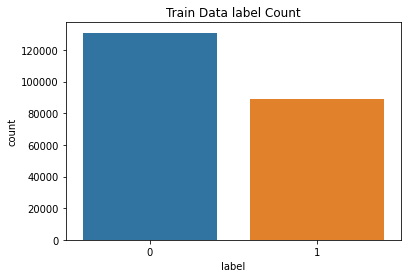

In [21]:
sns.countplot(data = train_label, x = 'label')
plt.title("Train Data label Count")

## ***B. Train Label Percentage Pie Chart***

In [22]:
fig = px.pie(train_label, 
             values = train_label['label'].value_counts().values, 
             names = train_label['label'].unique())
fig.update_layout(
    title={
        'text': "Train Label Percentage Pie Chart",
        'y':.99,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

## ***C. Count Distribution of Test Data***

Text(0.5, 1.0, 'Test Data label Count')

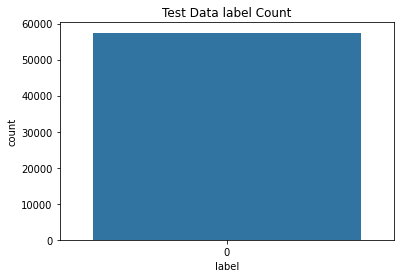

In [23]:
sns.countplot(data = test_label, x = 'label')
plt.title("Test Data label Count")

## ***D. Train Label Percentage Pie Chart***

In [24]:
fig = px.pie(test_label, 
             values = test_label['label'].value_counts().values, 
             names = test_label['label'].unique())
fig.update_layout(
    title={
        'text': "Test Label Percentage Pie Chart",
        'y':.99,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

## ***E. Printing Positive Images (Cancer Present) in Different Orientation***

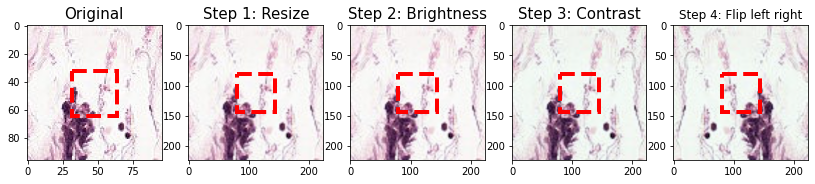

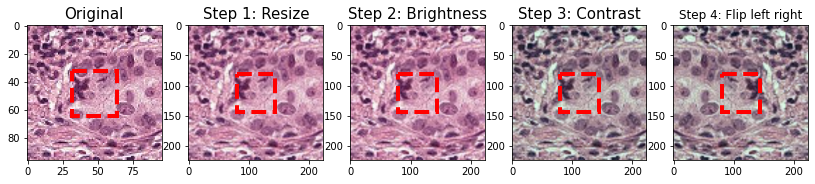

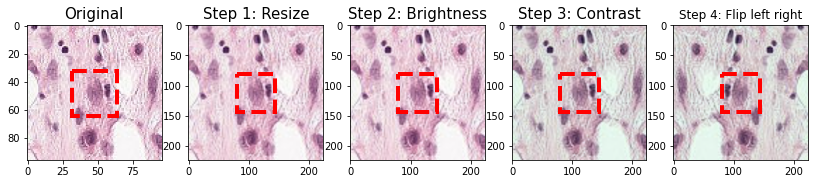

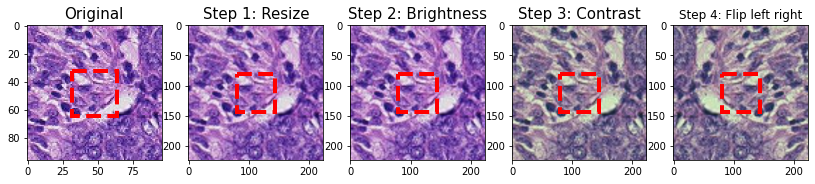

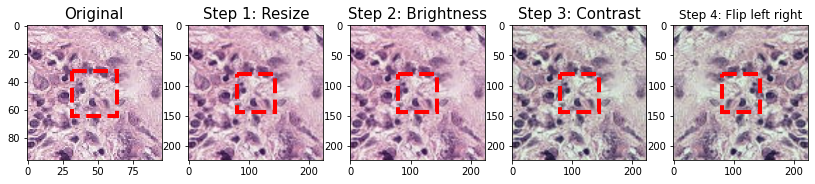

In [25]:
for image in train_positive_images_list[:5]:
    misc_proc.print_image_in_diff_orientation(image)

## ***F. Printing Negative Images (No Cancer) in Different Orientation***

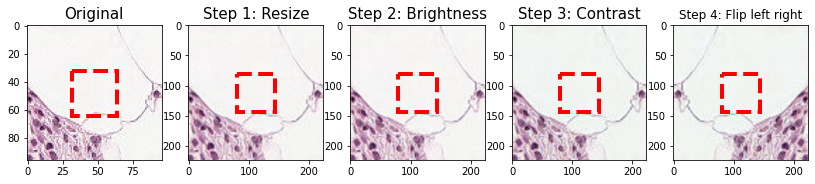

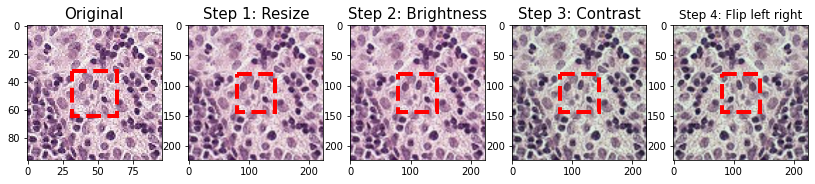

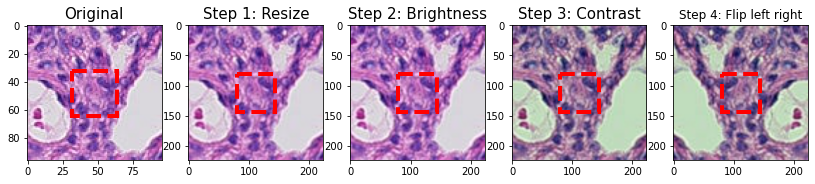

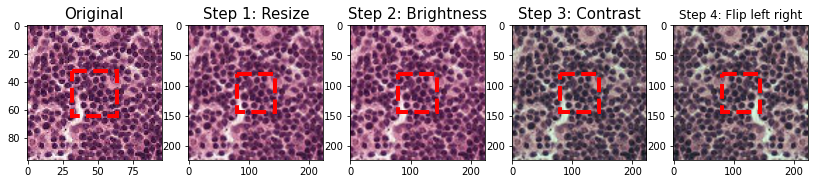

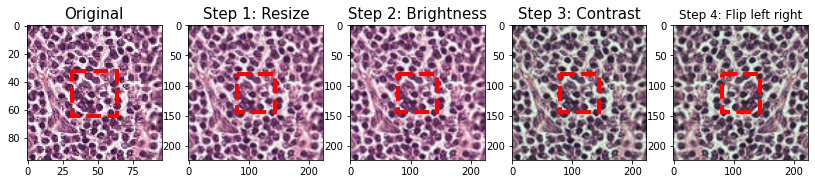

In [26]:
for image in train_negative_images_list[:5]:
    misc_proc.print_image_in_diff_orientation(image)

# ***8. Considerations***

## ***A. We see an imbalance between positive and negative images.***
We will consider equal number of positive and negative images for training and test data.


## ***B. We do not have correct label for test data.***
We will repurpose part of train data for testing.

# ***9. Data Processing***

## ***A. Shuffling Data***

In [27]:
# Shuffling data
shuffled_train_label = shuffle(train_label)
len_shuffled_train_label = len(shuffled_train_label)

# Selecting positive and negative images from the shuffled list
shuffled_train_positive_label_df = shuffled_train_label[shuffled_train_label.label == 1]
shuffled_train_negative_label_df = shuffled_train_label[shuffled_train_label.label == 0]

print(f"Length of shuffled_train_positive_label_df : {len(shuffled_train_positive_label_df)}")
print(f"Length of shuffled_train_negative_label_df : {len(shuffled_train_negative_label_df)}")

Length of shuffled_train_positive_label_df : 89117
Length of shuffled_train_negative_label_df : 130908


## ***B. Obtaining Split Indices***

In [28]:
split_indices = np.multiply(len(shuffled_train_positive_label_df), split).astype(int)
for idx, val in enumerate(split_indices):
    #print(idx, val)
    if idx > 0:
        split_indices[idx] = sum(split_indices[idx - 1 : idx]) + split_indices[idx]
print("Split indecs : ", split_indices)

Split indecs :  [26735 35646 44557]


## ***C. Spliting the Data***

To handle data imbalance problem, we will use equal number of positive and negative images. Thus, we will use 30% train positive, 30% train negative, 10% validation postive, 10% validation negative, 10% test positive and 10% test negative images.

In [29]:
# Splitting data at train, validation and test positions 
# for both positive and negative imgaes
# This process will select the list of ids
(X_train_id_positive, 
 X_val_id_positive, 
 X_test_id_positive) = misc_proc.split_data\
                       (split_indices = split_indices,\
                        df = shuffled_train_positive_label_df[:split_indices[-1]]
                       )
(X_train_id_negative, 
 X_val_id_negative, 
 X_test_id_negative) = misc_proc.split_data\
                       (split_indices = split_indices,\
                        df = shuffled_train_negative_label_df[:split_indices[-1]]
                       )
 
print(f"Length of X_train_id_positive : {len(X_train_id_positive)}")
print(f"Length of X_train_id_negative : {len(X_train_id_negative)}")

print(f"Length of X_val_id_positive : {len(X_val_id_positive)}")
print(f"Length of X_val_id_negative : {len(X_val_id_negative)}")

print(f"Length of X_test_id_positive : {len(X_test_id_positive)}")
print(f"Length of X_test_id_negative : {len(X_test_id_negative)}")

Length of X_train_id_positive : 26735
Length of X_train_id_negative : 26735
Length of X_val_id_positive : 8911
Length of X_val_id_negative : 8911
Length of X_test_id_positive : 8911
Length of X_test_id_negative : 8911


In [30]:
init_processing_train_file_list = X_train_id_positive['id'].values.tolist() + X_train_id_negative['id'].values.tolist()
init_processing_validation_file_list = X_val_id_positive['id'].values.tolist() + X_val_id_negative['id'].values.tolist()
init_processing_test_file_list = X_test_id_positive['id'].values.tolist() + X_test_id_negative['id'].values.tolist()

processing_train_file_list = shuffle(init_processing_train_file_list)
processing_validation_file_list = shuffle(init_processing_validation_file_list)
processing_test_file_list = shuffle(init_processing_test_file_list)

processing_qualified_train_file_list = shuffle([train_files_path + file + '.tif' for file in init_processing_train_file_list])
processing_qualified_validation_file_list = shuffle([train_files_path + file + '.tif' for file in init_processing_validation_file_list])
processing_qualified_test_file_list = shuffle([train_files_path + file + '.tif' for file in init_processing_test_file_list])

print(f"Length of processing_qualified_train_file_list : {len(processing_qualified_train_file_list)}")
print(f"Length of processing_qualified_validation_file_list : {len(processing_qualified_validation_file_list)}")
print(f"Length of processing_qualified_test_file_list : {len(processing_qualified_test_file_list)}")

Length of processing_qualified_train_file_list : 53470
Length of processing_qualified_validation_file_list : 17822
Length of processing_qualified_test_file_list : 17822


In [49]:
processing_qualified_train_file_list[0]

'/content/train/a7194decbb1642ee815fa042026a61e102049e2a.tif'

In [44]:
processing_train_label_list = train_label[train_label.id.isin(processing_train_file_list)].label.values
processing_validation_label_list = train_label[train_label.id.isin(processing_validation_file_list)].label.values
processing_test_label_list = train_label[train_label.id.isin(processing_test_file_list)].label.values

print(f"Length of processing_train_label_list : {len(processing_train_label_list)}")
print(f"Length of processing_validation_label_list : {len(processing_validation_label_list)}")
print(f"Length of processing_test_label_list : {len(processing_test_label_list)}")

Length of processing_train_label_list : 53470
Length of processing_validation_label_list : 17822
Length of processing_test_label_list : 17822


## ***D. Creating the Folder Structure***

In [32]:
!rm -rf /content/image_processing
!mkdir /content/image_processing
!mkdir /content/image_processing/train /content/image_processing/test /content/image_processing/validation

image_processing_train_path = "/content/image_processing/train/"
image_processing_validation_path = "/content/image_processing/validation/"
image_processing_test_path = "/content/image_processing/test/"

## ***E. Moving the Files under image_processing Folder***

In [33]:
misc_proc.process_copy_files(processing_qualified_train_file_list, image_processing_train_path)
misc_proc.process_copy_files(processing_qualified_validation_file_list, image_processing_validation_path)
misc_proc.process_copy_files(processing_qualified_test_file_list, image_processing_test_path)

print(f"File count under {image_processing_train_path} is {misc_proc.check_file_count_in_a_directory(image_processing_train_path)}")
print(f"File count under {image_processing_validation_path} is {misc_proc.check_file_count_in_a_directory(image_processing_validation_path)}")
print(f"File count under {image_processing_test_path} is {misc_proc.check_file_count_in_a_directory(image_processing_test_path)}")

Processing index:  0
Processing index:  10000
Processing index:  20000
Processing index:  30000
Processing index:  40000
Processing index:  50000
Processing index:  0
Processing index:  10000
Processing index:  0
Processing index:  10000
File count under /content/image_processing/train/ is 53470
File count under /content/image_processing/validation/ is 17822
File count under /content/image_processing/test/ is 17822


In [37]:
def get_model_classif_mobilenetv2():
    inputs = Input((96, 96, 3))
    base_model = DenseNet169(include_top=False, input_shape=(96, 96, 3))#, weights=None
    x = base_model(inputs)
    out1 = GlobalMaxPooling2D()(x)
    out2 = GlobalAveragePooling2D()(x)
    out3 = Flatten()(x)
    out = Concatenate(axis=-1)([out1, out2, out3])
    out = Dropout(0.5)(out)
    out = Dense(1, activation="sigmoid", name="3_")(out)
    model = Model(inputs, out)
    model.compile(optimizer=Adam(0.0001), loss=binary_crossentropy, metrics=['acc'])
    model.summary()
    return model

51877672/51877672 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 densenet169 (Functional)       (None, 3, 3, 1664)   12642880    ['input_1[0][0]']                
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 1664)        0           ['densenet169[0][0]']            
 xPooling2D)                                                                                      
                                                                                                  
 global_average_pooling2d (Gl

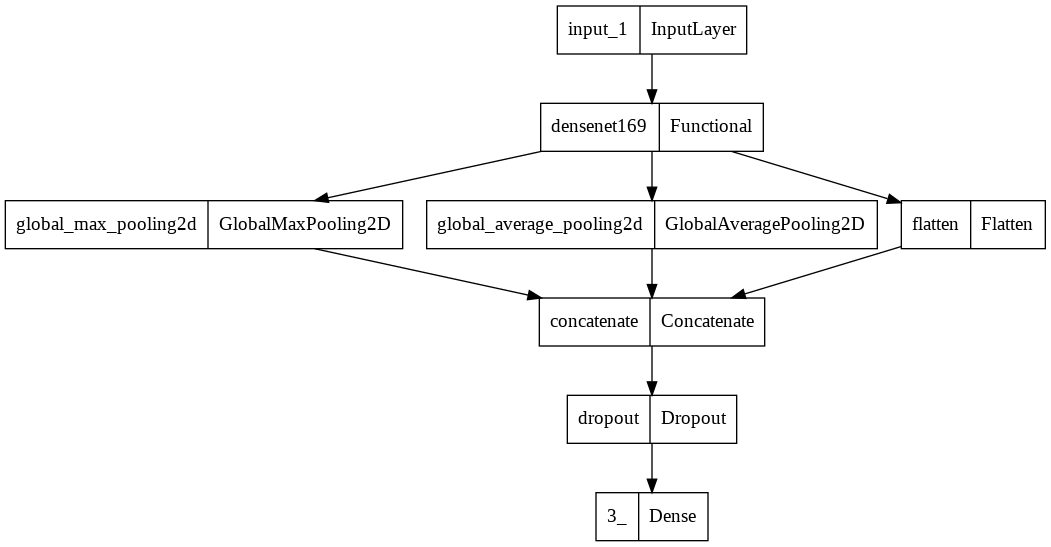

In [38]:
model = get_model_classif_mobilenetv2()
tf.keras.utils.plot_model(model)

In [ ]:
#batch_size=32
h5_path = "model.h5"
checkpoint = ModelCheckpoint(h5_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
tf.random.set_seed(1234)
np.random.seed(1234)
'''
history = model.fit_generator(
    image_data_generator(train, id_label_map, batch_size, augment=True),
    validation_data=image_data_generator(val, id_label_map, batch_size),
    epochs=2, verbose=1,
    callbacks=[checkpoint],
    steps_per_epoch=len(train) // batch_size,
    validation_steps=len(val) // batch_size)
train_label[train_label.id.isin(processing_train_file_list)]
'''
batch_size=64
history = model.fit_generator(
    misc_proc.image_data_generator(processing_qualified_train_file_list, 
                                   processing_train_label_list, 
                                   batch_size, 
                                   augment=True),
    validation_data = misc_proc.image_data_generator(processing_qualified_validation_file_list, 
                                                     processing_validation_label_list, 
                                                     batch_size),
    epochs = 10, 
    verbose = 1,
    callbacks=[checkpoint],
    steps_per_epoch = len(processing_train_file_list) // batch_size,
    validation_steps = len(processing_validation_file_list) // batch_size)

model.load_weights(h5_path)
tf.keras.backend.clear_session()
model.save('tumor_detection_base_model.h5')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.

/usr/local/lib/python3.7/dist-packages/imgaug/imgaug.py:184: DeprecationWarning:

Function `SimplexNoiseAlpha()` is deprecated. Use `BlendAlphaSimplexNoise` instead. SimplexNoiseAlpha is deprecated. Use BlendAlphaSimplexNoise instead. The order of parameters is the same. Parameter 'first' was renamed to 'foreground'. Parameter 'second' was renamed to 'background'.

/usr/local/lib/python3.7/dist-packages/imgaug/imgaug.py:184: DeprecationWarning:

Function `ContrastNormalization()` is deprecated. Use `imgaug.contrast.LinearContrast` instead.

/usr/local/lib/python3.7/dist-packages/imgaug/imgaug.py:184: DeprecationWarning:

Function `FrequencyNoiseAlpha()` is deprecated. Use `BlendAlphaFrequencyNoise` instead. FrequencyNoiseAlpha is deprecated. Use BlendAlphaFrequencyNoise instead. Th

In [ ]:
tf.keras.backend.clear_session()
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label = 'Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label = 'Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size = 15)
ax.set_ylabel('Accuracy', size = 15)
ax.set_ylim(0,1)
plt.show()

In [ ]:
test_results1 = model.evaluate(X_test, y_test)
print('\nTest Acc. {:.2f}%'.format(test_results1[1]*100))

In [ ]:
# transform logits to probabilities
pred_logits = model.predict(X_test)
probas = tf.sigmoid(pred_logits)
probas = probas.numpy().flatten()*100

In [ ]:
# plot test data and associated predicred
fig = plt.figure(figsize=(20, 20))

for j, example in enumerate(X_test[:20]):
    ax = fig.add_subplot(8, 4, j+1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(array_to_img(example))
    if y_test[j]==0:
        true_label = 'No Cancer'
    else:
        true_label = 'Cancer'
    
    ax.text(
        0.5, -0.15, 
        'True Label: {:s}\nPr(Cancer)={:.0f}%'.format(true_label, probas[j]), 
        size = 16, 
        color = 'grey',
        horizontalalignment = 'center',
        verticalalignment = 'center', 
        transform = ax.transAxes)
    
plt.tight_layout()
plt.show()

In [ ]:
predictions_baseline = [1 if x>50.0 else 0 for x in probas]
confusion_matrix_baseline = confusion_matrix(np.ceil(y_test).astype(int), predictions_baseline)
#plot_confusion_matrix(confusion_matrix_baseline, ['Cancer', 'No Cancer'])
print('ROC AUC Score = ',roc_auc_score(np.ceil(y_test).astype(int), predictions_baseline))

fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix_baseline,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True,
                                cmap = 'Dark2')
plt.show()

In [ ]:
fpr_baseline, tpr_baseline, thresholds_baseline = roc_curve(np.ceil(y_test).astype(int), predictions_baseline)
auc_baseline = auc(fpr_baseline, tpr_baseline)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_baseline, tpr_baseline, label='area = {:.2f}'.format(auc_baseline))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve Baseline')
plt.legend(loc='best')
plt.show()

In [ ]:
report_baseline = classification_report(np.ceil(y_test).astype(int), predictions_baseline, target_names = ['No Cancer', 'Cancer'])
print(report_baseline)